In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import os

## Importing dataset

In [ ]:
data_path="/content/drive/MyDrive/Es_project_data/Covid-19-PIS.v2i.multiclass/train"
csv_path="/content/drive/MyDrive/Es_project_data/Covid-19-PIS.v2i.multiclass/Copy of _classes.csv"
label_data=pd.read_csv(csv_path)

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
# imagePaths = list(paths.list_images(args["dataset"]))
imagePaths=list(paths.list_images(data_path))
data = []
labels = []
file_names=list(label_data["filename"].values)
for imagePath in imagePaths:
	index1=file_names.index(imagePath.split("/")[-1]) 
	if(label_data[" with_mask"][index1]==1):
		label="with_mask"
	else:
		label="without_mask"
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [ ]:
print(labels)

['with_mask' 'with_mask' 'with_mask' ... 'with_mask' 'without_mask'
 'without_mask']


### Splitting the dataset into training and testing 

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### Defining model parameters 

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

## Designing the model architecture

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


#### Compile the model with compile() method and train the model with fit() method

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
31/31 [==============================] - 71s 2s/step - loss: 0.5791 - accuracy: 0.7679 - val_loss: 0.2364 - val_accuracy: 0.9883
Epoch 2/10
31/31 [==============================] - 75s 2s/step - loss: 0.2255 - accuracy: 0.9617 - val_loss: 0.1071 - val_accuracy: 0.9961
Epoch 3/10
31/31 [==============================] - 65s 2s/step - loss: 0.1327 - accuracy: 0.9717 - val_loss: 0.0628 - val_accuracy: 0.9961
Epoch 4/10
31/31 [==============================] - 73s 2s/step - loss: 0.1007 - accuracy: 0.9818 - val_loss: 0.0445 - val_accuracy: 0.9961
Epoch 5/10
31/31 [==============================] - 64s 2s/step - loss: 0.0745 - accuracy: 0.9889 - val_loss: 0.0345 - val_accuracy: 0.9961
Epoch 6/10
31/31 [==============================] - 76s 2s/step - loss: 0.0594 - accuracy: 0.9919 - val_loss: 0.0281 - val_accuracy: 0.9961
Epoch 7/10
31/31 [==============================] - 75s 2s/step - loss: 0.0549 - accuracy: 0.9839 - val_loss: 

#### Making prediction and getting classification report 

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
# model.save(args["model"], save_format="h5")
model.save("mobilenet_model",save_format="h5")

[INFO] evaluating network...
8/8 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       129
without_mask       0.99      1.00      1.00       127

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

[INFO] saving mask detector model...


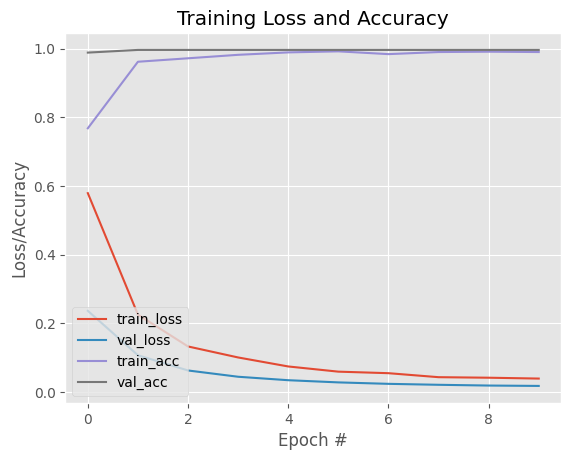

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

In [ ]:
_,acc=model.evaluate(testX,testY)
print(acc)

## Reducing the size of the neural network design


Effect on accuracy when number of epochs are changed

In [ ]:
acc1=[]
epoch=[]
for i in range(10,16):
  opt = Adam(learning_rate=INIT_LR)
  model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
  H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=i)
  _,acc=model.evaluate(testX,testY)
  acc1.append(acc*100)
  epoch.append(i)

In [ ]:
plt.plot(epoch, acc1 )
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
plt.title('Effect on accuracy when number of epochs are changed')
plt.legend()
plt.show()

## Model robustness check

In [ ]:
original_w = model.get_weights()

In [ ]:
weights=original_w

In [ ]:
num_layers=4

Defining scalars and changing weights of every layer by multipyling those scalars one by one

In [ ]:
accuracys=[]
x=num_layers-1
for i in range(len(original_w)-2,len(original_w)-1-(2*x),-2):
  accuracy=[]
  print("Layer :",x)
  for scalar in [.25, 0.4, 0.6, 0.85, 0.96,1, 1.1,1.25,1.5,1.75,2.]:
    new_w=[]
    for w in range(len(original_w)):
      if(w==i):
        new_w.append(original_w[w]*scalar)
      else:
        new_w.append(original_w[w])
    model.set_weights(new_w)
    evaluation = model.evaluate(testX, testY)
    print("Scalar {} --> test accuracy {}".format(scalar,evaluation[1]))
    accuracy.append(evaluation[1])
    model.set_weights(original_w)
  x-=1
  model.set_weights(original_w)
  accuracys.append(accuracy)

Plotting graph for each layer for each scalar multiplied vs accuracy 

In [ ]:
scalars=[.25, 0.4, 0.6, 0.85, 0.96, 1, 1.1,1.25,1.5,1.75,2.]
for i in range(len(accuracys)):
  plt.plot(scalars, accuracys[i], label=f'layer {num_layers-i-1}')
plt.xlabel('Scalar')
plt.ylabel('Accuracy')
plt.title('Effect on accuracy when weights are multiplied by scalers')
plt.legend()
plt.show()

Defining scalars and changing weights of every layer by adding those scalars one by one

In [ ]:
accuracys=[]
x=num_layers-1
for i in range(len(original_w)-2,len(original_w)-1-(2*x),-2):
  accuracy=[]
  print("Layer :",x)
  for scalar in [.25, 0.4, 0.6, 0.85, 0.96,1, 1.1,1.25,1.5,1.75,2.]:
    new_w=[]
    for w in range(len(original_w)):
      if(w==i):
        new_w.append(original_w[w]+scalar)
      else:
        new_w.append(original_w[w])
    model.set_weights(new_w)
    evaluation = model.evaluate(testX, testY)
    print("Scalar {} --> test accuracy {}".format(scalar,evaluation[1]))
    accuracy.append(evaluation[1])
    model.set_weights(original_w)
  x-=1
  model.set_weights(original_w)
  accuracys.append(accuracy)

 Plotting graph for each layer for each scalar added vs accuracy

In [ ]:
scalars=[.25, 0.4, 0.6, 0.85, 0.96, 1, 1.1,1.25,1.5,1.75,2.]
for i in range(len(accuracys)):
  plt.plot(scalars, accuracys[i], label=f'layer {num_layers-i-1}')
plt.xlabel('Scalar')
plt.ylabel('Accuracy')
plt.title('Effect on accuracy when weights are added by scalers')
plt.legend()
plt.show()

Prediction on Image

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

#### Downloading opencv pakages

In [ ]:
# import urllib.request

# # Downloading deploy.prototxt file
# urllib.request.urlretrieve('https://github.com/opencv/opencv/raw/master/samples/dnn/face_detector/deploy.prototxt',
#                            '/content/deploy.prototxt')

# # Downloading res10_300x300_ssd_iter_140000.caffemodel file
# urllib.request.urlretrieve('https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel',
#                            '/content/res10_300x300_ssd_iter_140000.caffemodel')


Loading model and face detector files

In [ ]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/deploy.prototxt"
weightsPath="/content/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNetFromCaffe(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model=load_model("mobilenet_model")

[INFO] loading face detector model...
[INFO] loading face mask detector model...


#### Detection function for image input

In [ ]:
def detection_path(image_path):
  testing_image=image_path
  # image = cv2.imread(args["image"])
  image=cv2.imread(testing_image)
  orig = image.copy()
  (h, w) = image.shape[:2]
  # print(image.shape)

  re_image = cv2.resize(image, (300, 300)) # resize the image to (300, 300)
  blob = cv2.dnn.blobFromImage(re_image, 1.0, (300, 300),(104.0, 177.0, 123.0))
  # pass the blob through the network and obtain the face detections
  print("[INFO] computing face detections...")
  net.setInput(blob)
  detections = net.forward()
  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.95:
      # compute the (x, y)-coordinates of the bounding box for
      # the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

      # ensure the bounding boxes fall within the dimensions of
      # the frame
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
  # extract the face ROI, convert it from BGR to RGB channel
      # ordering, resize it to 224x224, and preprocess it
  face = image[startY:endY, startX:endX]
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
  face = cv2.resize(face, (224, 224))
  face = img_to_array(face)
  face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)

      # pass the face through the model to determine if the face
      # has a mask or not
  (mask, withoutMask) = model.predict(face)[0]
      # determine the class label and color we'll use to draw
      # the bounding box and text
  from google.colab.patches import cv2_imshow
  label = "Mask" if mask > withoutMask else "No Mask"
  print("Category:",label)
  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

      # include the probability in the label
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

      # display the label and bounding box rectangle on the output
      # frame
  cv2.putText(image, label, (startX, startY - 10),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

  # show the output image
  cv2_imshow(image)
  cv2.waitKey(0)

[INFO] computing face detections...
1/1 [==============================] - 1s 1s/step
Category: Mask


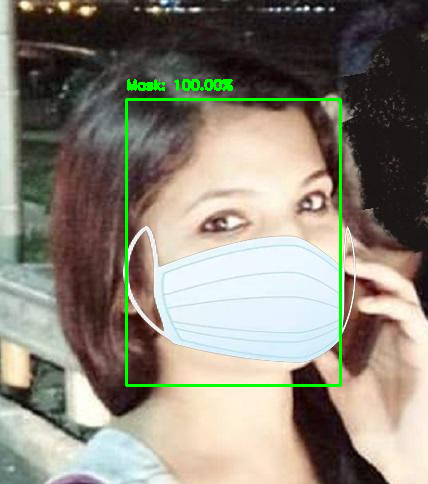

In [ ]:
image_path="/content/106-with-mask.jpg"   # give the image path...
detection_path(image_path)

### Input By Webcam

Enable Environment

In [ ]:
# !pip install virtualenv
# !virtualenv myenv
# !source myenv/bin/activate
# !pip install jupyter-webrtc


Input from Webcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement jupyter-webrtc (from versions: none)
ERROR: No matching distribution found for jupyter-webrtc


<IPython.core.display.Javascript object>

Image Saved, path='/content/sample.jpg'
Camera access granted


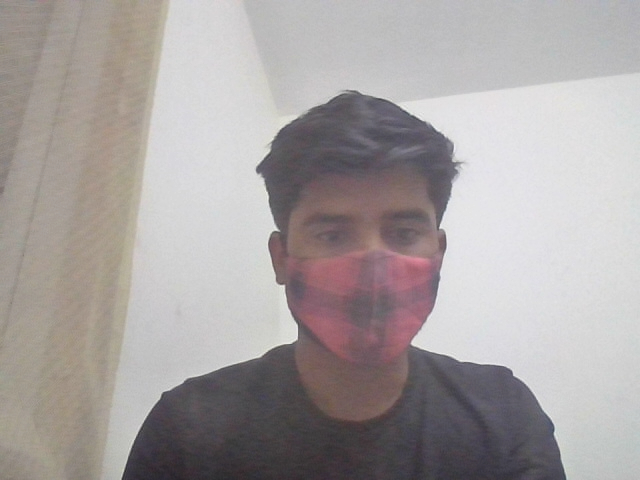

In [ ]:
from google.colab import drive
from google.colab import files
from IPython.display import display, Javascript
from PIL import Image
import io

# Install jupyter-webrtc
!pip install jupyter-webrtc

# Grant permission to the camera
def enable_camera():
  from google.colab.output import eval_js
  from base64 import b64decode
  from IPython.display import display
  from PIL import Image
  import io

  def takePhoto(filename='photo.jpg', quality=1.0):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const button = document.createElement('button');
        video.style.display = 'block';
        button.style.display = 'block';
        button.textContent = 'Capture';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(button);
        video.srcObject = stream;
        await video.play();
        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true, {maxHeight: 5000});
        await new Promise((resolve) => button.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    f = io.BytesIO(binary)
    img = Image.open(f)
    print("Image Saved, path='/content/sample.jpg'")
    img.save("/content/sample.jpg",'JPEG')
    return img


  try:
    img = takePhoto()
    print("Camera access granted")
    display(img)
  except Exception as e:
    print("Error accessing camera:", e)

enable_camera()


[INFO] computing face detections...
1/1 [==============================] - 0s 35ms/step
Category: Mask


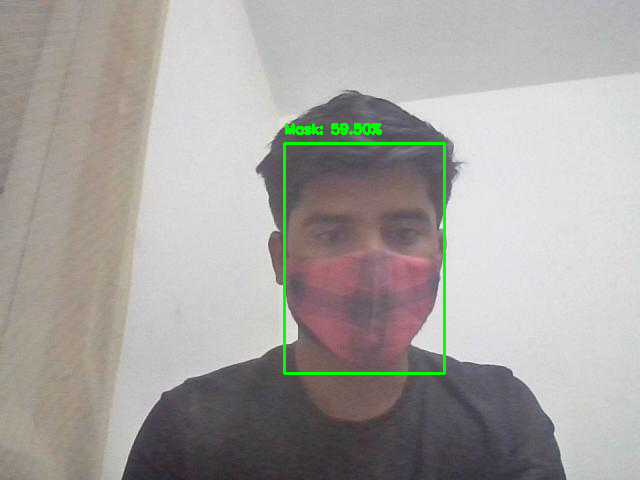

In [ ]:
image_path="/content/sample.jpg"
detection_path(image_path)

Quantization of model

In [ ]:
import tensorflow as tf

# Load the floating-point model
model = tf.keras.models.load_model('mobilenet_model')

# Convert the model to a quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_model = converter.convert()

# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)